# Third Iteration of Simulation SAoI

In this notebook, we will perform the third iteration of the SAoI simulation, with the goal of determining the optimal signal transmission frequency to minimize SAoI in the M/M/1 queue with a varying Carbon Intensity (CI) index.

In [5]:
import numpy as np 
from numpy import random 
import matplotlib.pyplot as plt 
from math import sin, pi
from collections import deque #We use deque for simulation of a queue

# We need to define function sinus that will represent value of CI over the time. 
def CI(t):
    """
    This function simulates value of CI (carbon intensity) over the time.

    Parameters
    ----------
    t: float
        Time parameter.

    Returns
    --------
    float
        Number that represents the value of CI for given time t.
    """
    return 100 * sin(t/(2*pi*3600*24)) + 300

In [6]:
def create_arrivals(arrival_rate, total_time):
    """Returns the list of arrival times of a M/M/1 queue
    with arrival rate arrival_rate and total time of the
    simulation total_time

    Parameters
    ----------
    arrival_rate: float
        Number between 0 and 1 that represents arrival rate of designed 
        M/M/1 queue

    total_time: int
        Total time of the simulation

    Returns
    --------
    list
       list of arrivals
    """ 
    list_of_arrivals = [0]
    for i in range(2*int(total_time/arrival_rate)):
        t = list_of_arrivals[-1] + random.exponential(1/arrival_rate)
        list_of_arrivals.append(t)
    return list_of_arrivals

In [7]:
#we need new data structure that will save the data of AoI and CF
def initialize_dic():
    """ 
    Returns dictionary with first 24 integer keys with None values.
    """
    dic = {}
    for i in range(24):
        dic[i] = None 
    return dic 

In [8]:
#we create class Packet in which we have objects that are our update packets
class Packet:
    """
    Elements of class Packet present packet updates with specific size, transmition time and generation time.
    """
    def __init__(self, size, trans, gen_time):
        self.size = size
        self.trans = trans
        self.gen_time = gen_time

    def transmit(self, time):
        self.trans -= time

In [19]:
#let one time unit be one tenth of a second.
def simulation_hourly(ar, ts=0.05):
    """Returns the average CT (carbon footprint) and AoI (age of 
    information) for each hour among time tt with time steps ts 
    for M/M/1 queue with arrival rate ar and serving rate 1.
    
    Parameters
    ----------
    ar: float
        Number between 0 and 1 that represents arrival rate of 
        designed M/M/1 queue.

    ts: float
        Number that represents the time step that we take at each 
        iteration of the loop.

    Returns
    ----------
    dictionary
        Value for each key is tuple of numbers that represent the 
        average CT and AoI for hour given with the index.
    """
    #we need list in which all of the times of arrivals are stored. 
    #Times in this list are absolute and not interarrival.
    list_of_arrivals = create_arrivals(ar, 360000*24)

    #we need list in which all of the times of servings are stored.
    #times in this list are interserving times and not absolute times.
    list_of_servings = random.exponential(scale=1, size=2*360000*24)

    ar_ind = 0 #helps us take the element with right index out of list_of_arrivals.
    ser_ind = 0 #helps us take the element with right index out of list_of_servings.
    time = 0 
    #we create dictionary in which we have keys that are numbers between 0 and 23. First 
    #element of the value tuple is average age for this hour and second average CF for this hour
    dicti = initialize_dic()

    age = 0
    queue = deque([]) 
    packet_list = []
    inter_serving_time = 0
    
    for ind in range(24):
        age_list = []
        CT_list = []
        for i in range(3600):
            #we use this double loop so that we refresh energy to 0 after every 100 time units. 
            for j in range(int(100/ts)):
                energy = 0 #we initialize energy to zero so that we will measure it for this 100 time units
                time += ts
                age += ts
                inter_serving_time += ts 
                if time > list_of_arrivals[ar_ind]:
                    energy += 18
                    packet_list.append(Packet(6, 5, time))
                    ar_ind += 1
                for inx in range(len(packet_list)):
                    pack = packet_list[inx]
                    pack.transmit(ts)
                    packet_list[inx] = pack
                if len(packet_list) != 0:
                    if packet_list[0].trans < 0:
                        queue.append(packet_list[0])
                        packet_list = packet_list[1:]
                if inter_serving_time > list_of_servings[ser_ind] and len(queue) != 0:
                    inter_serving_time = 0
                    energy += list_of_servings[ser_ind - 1] * 18
                    age = time - queue[0].gen_time
                    energy += age - 5
                    queue.popleft()
                    ser_ind += 1
                age_list.append(age)
            CT = energy * CI(time)
            CT_list.append(CT)
        #note that CT_list has 100/ts times less elements as age_list. When we take the 
        #average of both it is not the problem anymore and we can compare them.
        CT_avg = sum(CT_list)/len(CT_list)
        age_avg = sum(age_list)/len(age_list)
        dicti[ind] = (CT_avg, age_avg)
    return dicti

In [20]:
x_list = []
x = 0.1
for i in range(17):
    x_list.append(x)
    x += 0.05

#now we are going to create dictionary of age_values and CT_values for different hours
di_age = initialize_dic()
di_CT = initialize_dic()
dicti = simulation_hourly(x_list[0])
for jj in range(24):
    di_age[jj] = [dicti[jj][1]]
    di_CT[jj] = [dicti[jj][0]]
for e in x_list[1:]:
    dicti = simulation_hourly(e)
    for ii in range(24):
        di_age[ii].append(dicti[ii][1])
        di_CT[ii].append(dicti[ii][0])

x_values = np.array(x_list)
age_values = np.array(di_age[0])
CT_values = np.array(di_CT[0])

plt.plot(age_values, CT_values)
plt.xlabel("AoI")
plt.ylabel("CT")
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


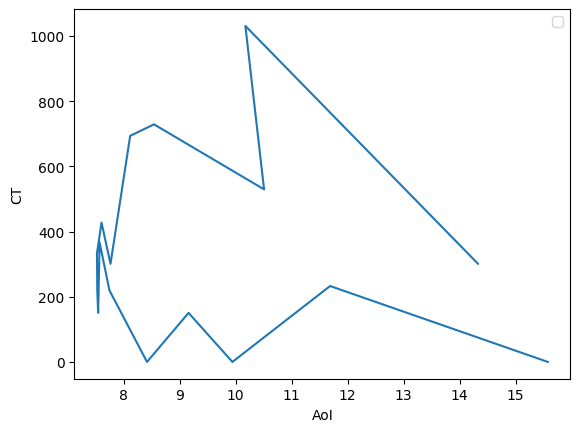

In [15]:
age_values = np.array(di_age[1])
CT_values = np.array(di_CT[1])

plt.plot(age_values, CT_values)
plt.xlabel("AoI")
plt.ylabel("CT")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


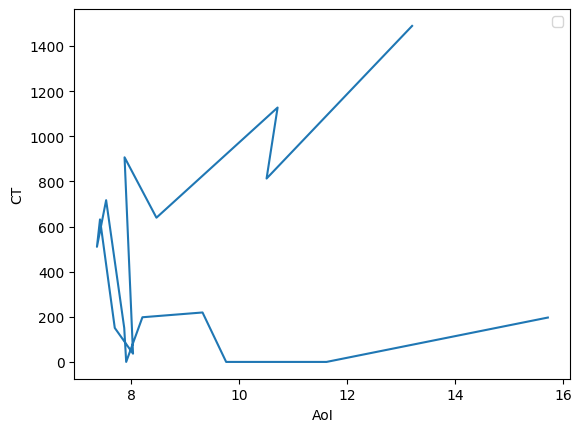

In [16]:
age_values = np.array(di_age[2])
CT_values = np.array(di_CT[2])

plt.plot(age_values, CT_values)
plt.xlabel("AoI")
plt.ylabel("CT")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


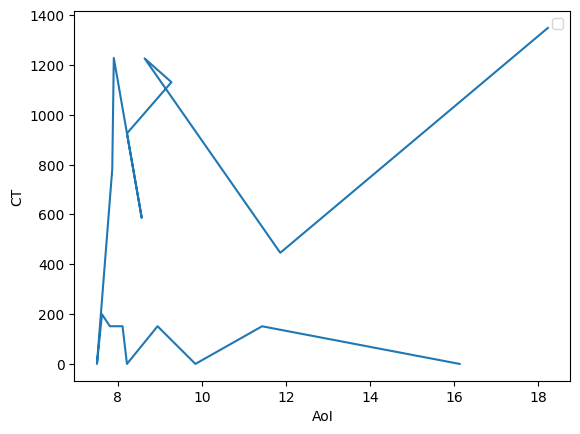

In [17]:
age_values = np.array(di_age[3])
CT_values = np.array(di_CT[3])

plt.plot(age_values, CT_values)
plt.xlabel("AoI")
plt.ylabel("CT")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


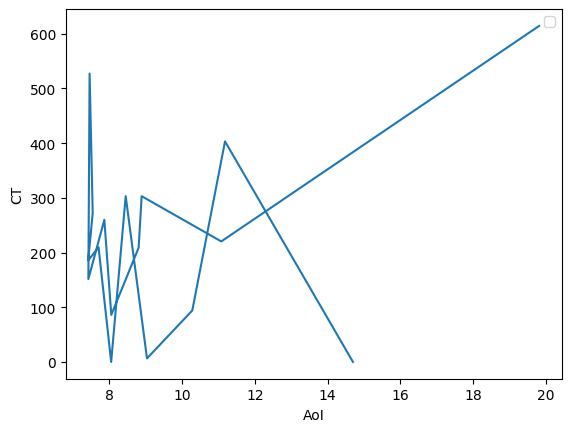

In [18]:
age_values = np.array(di_age[4])
CT_values = np.array(di_CT[4])

plt.plot(age_values, CT_values)
plt.xlabel("AoI")
plt.ylabel("CT")
plt.legend()
plt.show()